In [1]:
import sys
sys.path.append('../python/')
import ana
import ap
import aux
import cfg
import db
import fio
import lex

## Load basic data

In [2]:
corpus_id = cfg.CORPUS_ID_SB

In [3]:
# this cell takes about a minute
db.connect(corpus_id)
# get wide table with basic data
df_bt = ap.load_data(cfg.NRM_SPK, ['gender'])
db.close()

In [4]:
# # takes about 10 mins (only needed if measures are recomputed)
# df_spk_pairs = db.pd_read_sql_query(sql_fname=cfg.SQL_SP_FNAME)
# # limit to sessions and get entropy weights
# df_spk_pairs_ses = df_spk_pairs[df_spk_pairs['tsk_id'] == 0]
# df_spk_pairs_ses = lex.get_entropy_weights(
#     corpus_id, df_spk_pairs_ses)
# # get 25 most frequent types in the corpus
# mf_types = lex.get_mf_types(corpus_id)
# db.close()

## Compute/load acoustic measures

In [5]:
# local similarity (about 3 mins to recompute)
df_lsim, _ = fio.load_pickle_dumps(corpus_id, cfg.MEA_LSIM)
if df_lsim is None:
    df_lsim = ap.lsim(df_bt, [cfg.GRP_BY_SES])
    fio.write_pickle_dumps(corpus_id, cfg.MEA_LSIM, df_lsim)

In [6]:
# synchrony (about 2 mins to recompute)
df_syn, _ = fio.load_pickle_dumps(corpus_id, cfg.MEA_SYN)
if df_syn is None:
    df_syn = ap.syn(df_bt, [cfg.GRP_BY_SES])
    fio.write_pickle_dumps(corpus_id, cfg.MEA_SYN, df_syn)

In [7]:
# local convergence (about 1 min to recompute)
df_lcon, _ = fio.load_pickle_dumps(corpus_id, cfg.MEA_LCON)
if df_lcon is None:
    df_lcon = ap.lcon(df_bt, [cfg.GRP_BY_SES])
    fio.write_pickle_dumps(corpus_id, cfg.MEA_LCON, df_lcon)

In [8]:
# global convergence (seconds to recompute)
df_gcon, df_gcon_raw = fio.load_pickle_dumps(corpus_id, cfg.MEA_GCON)
if df_gcon is None or df_gcon_raw is None:
    df_gcon, df_gcon_raw = ap.gcon(df_bt)    
    fio.write_pickle_dumps(
        corpus_id, cfg.MEA_GCON, df_gcon, df_gcon_raw)

In [9]:
# global similarity (seconds to recompute)
df_gsim, df_gsim_raw = fio.load_pickle_dumps(corpus_id, cfg.MEA_GSIM)
if df_gsim is None or df_gsim_raw is None:
    df_gsim, df_gsim_raw = ap.gsim(df_bt, df_spk_pairs)
    fio.write_pickle_dumps(
        corpus_id, cfg.MEA_GSIM, df_gsim, df_gsim_raw)

## Compute/load lexical measures

In [10]:
# perplexity measure (about 5 HOURS to recompute on my machine)
df_ppl, df_ppl_raw = fio.load_pickle_dumps(corpus_id, cfg.MEA_PPL)
if df_ppl is None or df_ppl_raw is None:
    df_ppl, df_ppl_raw = lex.ppl(corpus_id, df_spk_pairs_ses)
    fio.write_pickle_dumps(corpus_id, cfg.MEA_PPL, df_ppl, df_ppl_raw)

In [11]:
# most frequent types measure (about 1 min to recompute)
df_hfw, df_hfw_raw = fio.load_pickle_dumps(corpus_id, cfg.MEA_HFW)
if df_hfw is None or df_hfw_raw is None:
    df_hfw, df_hfw_raw = lex.dist_sim(
        corpus_id, df_spk_pairs_ses, 
        types_id=cfg.TYPES_ID_MF, types=mf_types)
    fio.write_pickle_dumps(corpus_id, cfg.MEA_HFW, df_hfw, df_hfw_raw)

In [12]:
# kullback-leibler divergence measure (about 12 mins to recompute)
df_kld, df_kld_raw = fio.load_pickle_dumps(corpus_id, cfg.MEA_KLD)
if df_kld is None or df_kld_raw is None:
    df_kld, df_kld_raw = lex.kld(corpus_id, df_spk_pairs_ses)
    fio.write_pickle_dumps(corpus_id, cfg.MEA_KLD, df_kld, df_kld_raw)

In [13]:
# samples for further analysis (correlation, chisquare, clustering, pca)
# (all measures; tasks and sessions are the same in switchboard)
dict_df_meas = {
    cfg.MEA_GSIM: df_gsim_raw,
    cfg.MEA_GCON: df_gcon_raw,
    cfg.MEA_LSIM: df_lsim,
    cfg.MEA_LCON: df_lcon,
    cfg.MEA_SYN:  df_syn,
    cfg.MEA_KLD:  df_kld_raw,
    cfg.MEA_PPL:  df_ppl_raw,
    cfg.MEA_HFW:  df_hfw_raw
}
df_samples_ses, df_chi_ses = ana.get_samples(
    df_bt, dict_df_meas, tsk_or_ses='ses', nrm=True)

# Results overview

In [14]:
df_gsim

,intensity_mean,pitch_mean,rate_syl
ses_type,,,
0,"(6.3751451270755055, 1.997898423433957e-10, 4843)","(10.09856414532759, 9.617632541420725e-24, 4843)","(14.914111475729133, 3.2528472120857982e-49, 4..."
CONV,"(6.3751451270755055, 1.997898423433957e-10, 4843)","(10.09856414532759, 9.617632541420725e-24, 4843)","(14.914111475729133, 3.2528472120857982e-49, 4..."


In [15]:
df_gcon

,intensity_mean,pitch_mean,rate_syl
ses_type,,,
0,"(0.9953741888676957, 0.3196533303985841, 2432)","(-1.735171109683876, 0.08283718012258796, 2432)","(-3.2077178102545356, 0.0013553085174760615, 2..."
CONV,"(0.9953741888676957, 0.3196533303985841, 2432)","(-1.735171109683876, 0.08283718012258796, 2432)","(-3.2077178102545356, 0.0013553085174760615, 2..."


In [16]:
df_lsim.xs([0,0], level=[2,3])

intensity_mean  \
ses_type ses_id                                                      
CONV     2001    (1.3616910561637832, 0.1817567926766804, 36, -...   
         2005    (-1.2418869196280837, 0.21799956015509706, 78,...   
         2006    (1.074110844796401, 0.28920998837837003, 40, -...   
         2007    (1.4165083793049569, 0.16060815770921968, 78, ...   
         2008    (-0.3763878304335766, 0.7088378657971648, 36, ...   
...                                                            ...   
         4926    (0.019992702572760992, 0.9842018351146086, 26,...   
         4927    (1.334118393243262, 0.18704485494329146, 62, -...   
         4928    (0.2192450934356046, 0.8276974835861107, 36, -...   
         4936    (0.2950113012534039, 0.7693126751283712, 46, -...   
         4940    (-0.48269350206756706, 0.6310133583926932, 62,...   

                                                        pitch_mean  \
ses_type ses_id                                                      
CONV     2001    (1.052428551325771, 0.2996160963846407, 36, -0...   
         2005    (-1.4528707633543745, 0.15027092841225204, 78,...   
         2006    (0.3710837366023677, 0.7125333877569304, 40, -...   
         2007    (0.4579933813343678, 0.6482305659137446, 78, -...   
         2008    (3.105421196453812, 0.0036929559305784875, 36,...   
...                                                            ...   
         4926    (0.053552843524233736, 0.9577007958488633, 26,...   
         4927    (2.1805596199177493, 0.03301961953258227, 62, ...   
         4928    (0.17853327468166347, 0.8593051270569141, 36, ...   
         4936    (0.138165937626906, 0.8907123359276896, 46, -1...   
         4940    (1.114508116329574, 0.26936300116800393, 62, -...   

                                                          rate_syl  
ses_type ses_id                                                     
CONV     2001    (-0.4059685601630988, 0.6871687449323137, 36, ...  
         2005    (-0.9691908312836871, 0.335445737385894, 78, -...  
         2006    (-1.5406287330082138, 0.13128178133062723, 40,...  
         2007    (-0.32738549646995324, 0.7442533793172872, 78,...  
         2008    (-0.997970628834279, 0.32495462230754435, 36, ...  
...                                                            ...  
         4926    (-0.9807636591372314, 0.33574797708710347, 26,...  
         4927    (-1.6432240702748102, 0.1053989850610652, 62, ...  
         4928    (1.184793828637914, 0.24386188707836767, 36, -...  
         4936    (-1.5617796980584473, 0.1251941629517401, 46, ...  
         4940    (-0.7650649053235283, 0.4471353768184896, 62, ...  

[2435 rows x 3 columns]

In [17]:
df_lcon.xs([0,0], level=[2,3])

intensity_mean  \
ses_type ses_id                                                     
CONV     2001     (-0.057246178013598666, 0.7364641001875878, 35)   
         2005    (-0.0010362251322033195, 0.9927685779544662, 77)   
         2006      (-0.02287246319727363, 0.8871238512023846, 39)   
         2007     (-0.010332448741645572, 0.9279889068577981, 77)   
         2008       (0.11061008147727425, 0.5145775519511364, 35)   
...                                                           ...   
         4926    (-0.0030546131561190668, 0.9879355101783664, 25)   
         4927     (-0.17843624184062498, 0.16175601336522938, 61)   
         4928       (0.09168347523250085, 0.5894133093623546, 35)   
         4936      (0.044883010602781506, 0.7645069159403524, 45)   
         4940      (0.15837999112943668, 0.21505997309124392, 61)   

                                                      pitch_mean  \
ses_type ses_id                                                    
CONV     2001      (0.13350172877859104, 0.4308587282740091, 35)   
         2005    (-0.15807068790984058, 0.16412433832225168, 77)   
         2006    (-0.30509158229530653, 0.05242225695744455, 39)   
         2007    (-0.12427916280293767, 0.27516388179417733, 77)   
         2008      (-0.03968588461409825, 0.815601358799242, 35)   
...                                                          ...   
         4926       (0.1753234319945571, 0.3817355283514919, 25)   
         4927     (-0.1729850028588284, 0.17517010831234409, 61)   
         4928        (-0.0988049961446372, 0.56069745167032, 35)   
         4936     (0.022271736990541288, 0.8818738749909717, 45)   
         4940     (-0.11843971105876382, 0.3552153246870993, 61)   

                                                        rate_syl  
ses_type ses_id                                                   
CONV     2001    (-0.14564931122242164, 0.38971064767098623, 35)  
         2005      (0.2008416961989674, 0.07593111713855606, 77)  
         2006      (0.06972479756143309, 0.6648857555146164, 39)  
         2007      (0.04618192455613228, 0.6861045945323626, 77)  
         2008      (0.2773123177406611, 0.09657295502209645, 35)  
...                                                          ...  
         4926      (-0.0961748372857836, 0.6332190667603749, 25)  
         4927     (-0.006449208216949359, 0.959991343648396, 61)  
         4928      (0.09278145066504728, 0.5849439527860355, 35)  
         4936     (0.015169104593240463, 0.9193920345297866, 45)  
         4940    (0.0027095005603116062, 0.9831855348517404, 61)  

[2435 rows x 3 columns]

In [18]:
df_syn.xs([0,0], level=[2,3])

intensity_mean  \
ses_type ses_id                                                    
CONV     2001      (0.07455349800382967, 0.6609967151676085, 35)   
         2005    (-0.2221996264363685, 0.049050414541524846, 77)   
         2006     (0.26663568431286744, 0.09195692787703934, 39)   
         2007    (0.22493090630097717, 0.046263488371724656, 77)   
         2008      (0.07280688776761847, 0.6684794283198536, 35)   
...                                                          ...   
         4926      (-0.1837630427495997, 0.3588673550210828, 25)   
         4927     (0.23482900261774017, 0.06394386404430298, 61)   
         4928     (0.17509736239448265, 0.29994346525610277, 35)   
         4936      (0.14426906108068363, 0.3332942916595741, 45)   
         4940     (-0.1720311475500767, 0.17759815377100466, 61)   

                                                      pitch_mean  \
ses_type ses_id                                                    
CONV     2001     (0.32320410331733684, 0.05103055223918297, 35)   
         2005     (0.022923709907268528, 0.8410668073559966, 77)   
         2006      (0.10698941614125525, 0.5055417060209058, 39)   
         2007     (0.056838594261400394, 0.6188064466357918, 77)   
         2008    (0.44069394406231704, 0.006335086586725497, 35)   
...                                                          ...   
         4926    (-0.017557434770272166, 0.9307346010637428, 25)   
         4927      (0.2241467264378605, 0.07739093632970263, 61)   
         4928      (0.05551847991803362, 0.7441469497672184, 35)   
         4936     (-0.07318271353631851, 0.6249395446103087, 45)   
         4940      (0.1242918431065263, 0.33177203951101825, 61)   

                                                        rate_syl  
ses_type ses_id                                                   
CONV     2001     (-0.09434139274520048, 0.5786201898350122, 35)  
         2005     (-0.07630649236418115, 0.5038833793623971, 77)  
         2006     (-0.1945230035316986, 0.22295114340028543, 39)  
         2007      (-0.0735408655826087, 0.5195106323217294, 77)  
         2008    (-0.22664395063161025, 0.17735823608987358, 35)  
...                                                          ...  
         4926     (-0.3292618113928072, 0.09352827639101466, 25)  
         4927    (-0.2686216774982131, 0.033277629852094634, 61)  
         4928      (0.06410708653862976, 0.7062090307274462, 35)  
         4936       (-0.2736300173711023, 0.062730986488423, 45)  
         4940     (0.026337893825248055, 0.8376503925817784, 61)  

[2435 rows x 3 columns]

In [19]:
df_ppl

,raw,wgh
ses_type,,
0,"(37.89578059932346, 1.8931857772171168e-275, 4...","(33.895838278794734, 3.5062634719188576e-226, ..."
CONV,"(37.89578059932346, 1.8931857772171168e-275, 4...","(33.895838278794734, 3.5062634719188576e-226, ..."


In [20]:
# average partner vs. average non-partner similarity, relative to stdev
p = df_ppl_raw.xs((0,0), level=(2,3))['ppl_p']
x = df_ppl_raw.xs((0,0), level=(2,3))['ppl_wgh_x']

(p.mean() - x.mean()) / ((p.std() + x.std()) / 2)

0.4450331202536834

In [21]:
df_hfw

,raw,wgh
ses_type,,
0,"(20.804419349109864, 3.802831271174635e-92, 4843)","(20.801248876959033, 4.040747739067842e-92, 4843)"
CONV,"(20.804419349109864, 3.802831271174635e-92, 4843)","(20.801248876959033, 4.040747739067842e-92, 4843)"


In [22]:
# average partner vs. average non-partner similarity, relative to stdev
p = df_hfw_raw.xs((0,0), level=(2,3))['dsim_p']
x = df_hfw_raw.xs((0,0), level=(2,3))['dsim_wgh_x']
(p.mean() - x.mean()) / ((p.std() + x.std()) / 2)

0.33922342294646624

In [23]:
df_kld

,raw,wgh
ses_type,,
0,"(123.91305072394215, 0.0, 4843)","(117.95768687022407, 0.0, 4843)"
CONV,"(123.91305072394215, 0.0, 4843)","(117.95768687022407, 0.0, 4843)"


In [24]:
# average partner vs. average non-partner similarity, relative to stdev
p = df_kld_raw.xs((0,0), level=(2,3))['kld_p']
x = df_kld_raw.xs((0,0), level=(2,3))['kld_wgh_x']
(p.mean() - x.mean()) / ((p.std() + x.std()) / 2)

3.2260001072845594

In [25]:
ana.bh(ana.correlate_columns(df_samples_ses))

([('lsim_i', 'syn_i', 0.5681252427468367, 6.580730221817656e-207),
  ('lsim_p', 'syn_p', 0.5280184837114568, 7.479213677959565e-174),
  ('gsim_i', 'syn_i', 0.49570142889963026, 2.827267527866019e-150),
  ('gcon_i', 'lcon_i', 0.39398189717420434, 1.1109172261201575e-90),
  ('lsim_r', 'syn_r', 0.24442364698212354, 2.9812509580669647e-34),
  ('kld', 'ppl', 0.21539849914327336, 8.492152199161034e-27),
  ('ppl', 'dsim', 0.21103665847994751, 9.139128835981221e-26),
  ('gcon_p', 'lcon_p', 0.1886156268913068, 8.127480979883224e-21),
  ('gsim_p', 'syn_p', 0.18498259338137987, 4.535723817997528e-20),
  ('syn_i', 'syn_p', 0.14810766937161832, 2.4323386791596806e-13),
  ('gcon_r', 'lcon_r', 0.12521282554378696, 6.377239474316036e-10),
  ('lsim_i', 'lsim_p', 0.11989761451097142, 3.288863260641022e-09),
  ('lsim_p', 'syn_i', 0.10744062080511711, 1.1708396437619855e-07),
  ('kld', 'dsim', 0.1016472203750702, 5.420948329796807e-07),
  ('lsim_r', 'lcon_i', -0.10138932507243693, 5.792732900726886e-07),


In [26]:
ana.bh(ana.chisquare(df_chi_ses))

([('lsim_r_chi', 'syn_r_chi', 555.5421210773629, 7.840874071966667e-123),
  ('lsim_i_chi', 'syn_i_chi', 477.54190562871156, 7.321875610774698e-106),
  ('lsim_p_chi', 'syn_p_chi', 347.7568319958492, 1.3050454710530424e-77),
  ('gsim_i_chi', 'syn_i_chi', 338.5016170800818, 1.3526761427702618e-75),
  ('gcon_i_chi', 'lcon_i_chi', 149.84188507933456, 1.877240902052504e-34),
  ('syn_i_chi', 'syn_p_chi', 44.113020495982504, 3.099523250868902e-11),
  ('gsim_p_chi', 'syn_p_chi', 43.82880181018698, 3.5839191805881074e-11),
  ('ppl_chi', 'dsim_chi', 35.928152805741654, 2.0472909813653527e-09),
  ('gcon_p_chi', 'lcon_p_chi', 25.48996880077927, 4.4468897722459744e-07),
  ('lsim_p_chi', 'syn_i_chi', 20.58732803046367, 5.697197838248883e-06),
  ('lsim_i_chi', 'lsim_p_chi', 20.213428677528558, 6.926499824593129e-06),
  ('lsim_i_chi', 'syn_p_chi', 19.865593165133774, 8.308225463059686e-06),
  ('gcon_r_chi', 'lcon_r_chi', 17.460195204250397, 2.9338660719493656e-05),
  ('lsim_r_chi', 'ppl_chi', 14.187479

In [27]:
kmeans = ana.kmeans(df_samples_ses, 40, 100)

clustering real data
starting k=2 at Fri May  6 17:58:55 2022
starting k=3 at Fri May  6 17:59:10 2022
starting k=4 at Fri May  6 17:59:28 2022
starting k=5 at Fri May  6 17:59:46 2022
starting k=6 at Fri May  6 18:00:06 2022
starting k=7 at Fri May  6 18:00:26 2022
starting k=8 at Fri May  6 18:00:47 2022
starting k=9 at Fri May  6 18:01:07 2022
starting k=10 at Fri May  6 18:01:27 2022
starting k=11 at Fri May  6 18:01:48 2022
starting k=12 at Fri May  6 18:02:08 2022
starting k=13 at Fri May  6 18:02:29 2022
starting k=14 at Fri May  6 18:02:50 2022
starting k=15 at Fri May  6 18:03:13 2022
starting k=16 at Fri May  6 18:03:35 2022
starting k=17 at Fri May  6 18:03:56 2022
starting k=18 at Fri May  6 18:04:16 2022
starting k=19 at Fri May  6 18:04:39 2022
starting k=20 at Fri May  6 18:04:59 2022
starting k=21 at Fri May  6 18:05:20 2022
starting k=22 at Fri May  6 18:05:43 2022
starting k=23 at Fri May  6 18:06:03 2022
starting k=24 at Fri May  6 18:06:25 2022
starting k=25 at Fri 

<IPython.core.display.Javascript object>


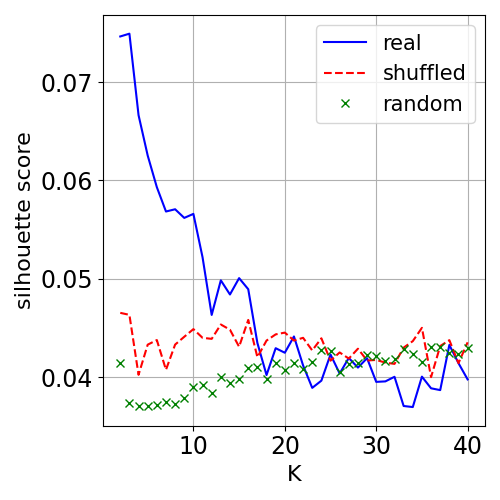

In [28]:
ana.plot_kmeans_scores(kmeans, 'sil')

In [29]:
import pickle
with open('../../data/sb/dumps/kmeans.pickle', 'wb') as pickle_file:
    pickle.dump(kmeans, pickle_file)

explained variance ratio per dimension:
 [0.10906729 0.08270219 0.08013642 0.07513871 0.06940872 0.06772243
 0.06191618 0.05881065 0.05443538 0.05124982 0.04691969 0.04571246
 0.04498733 0.0419099  0.03867574 0.03200556 0.02449425 0.01470728]
dimensions required to retain 0.90 of variance: 15
dimensions required to retain 0.95 of variance: 16
dimensions required to retain 0.99 of variance: 18
fraction of variance retained in 3D: 0.27190590371482254


<IPython.core.display.Javascript object>


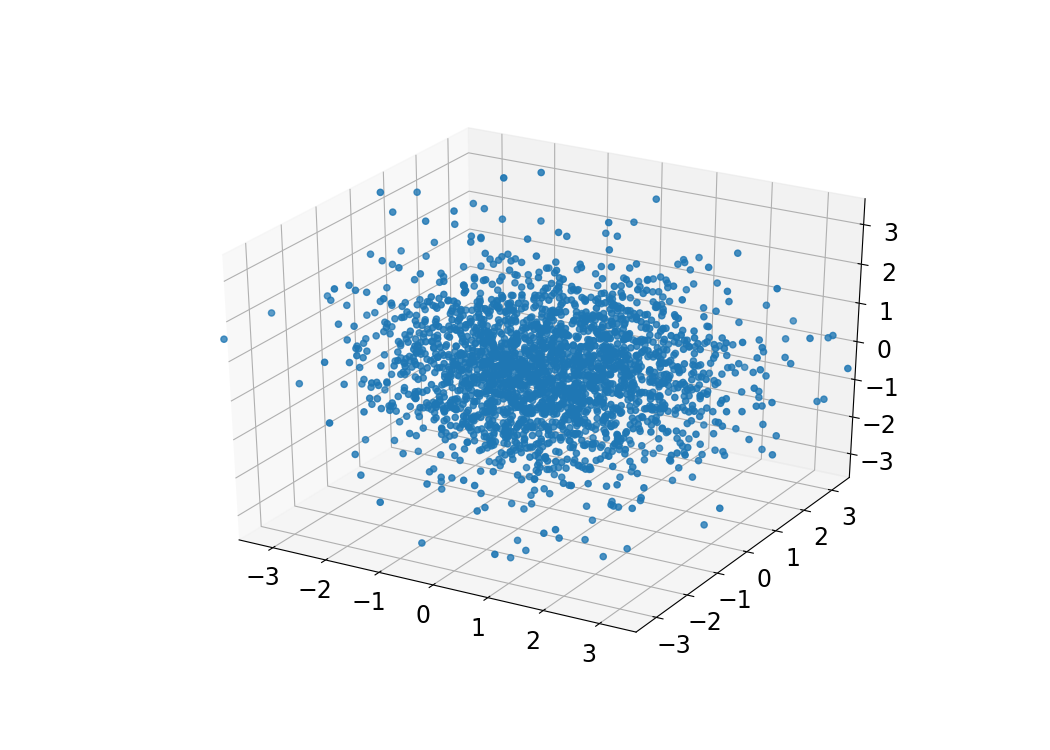

In [30]:
ana.pca(df_samples_ses)

In [31]:
# check whether clusters for k=2 separate gender pairs
import pandas as pd
labels = kmeans[0]['kmeans'][0].labels_
gps = [v[2] for v in df_samples_ses.index]
df_tmp = pd.DataFrame(zip(labels, gps, list(range(len(gps)))), 
                      columns=['lb', 'gp', '_'])
ana.chisquare(df_tmp, [0,1], ['f', 'm', 'x'], 1)

[('lb',
  'gp',
  33.77905855050821,
  4.623497571103647e-08,
  2,
  array([[303.84297521, 328.33884298, 507.81818182],
         [341.15702479, 368.66115702, 570.18181818]]),
  array([[245, 373, 522],
         [400, 324, 556]]))]

In [32]:
# check whether random clusters separate gender pairs
import math 
import numpy as np

def ed(v1, v2):
    return math.sqrt(sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

ps = []
for run in range(100):
    rng = np.random.default_rng()
    c0 = [rng.normal(0, 1) for i in range(18)]
    c1 = [-v for v in c0]
    dists0 = [ed(c0, v) for v in df_samples_ses.values]
    dists1 = [ed(c1, v) for v in df_samples_ses.values]
    labels = [0 if dists0[i] < dists1[i] else 1 
              for i in range(len(dists0))]
    gps = [v[2] for v in df_samples_ses.index]
    df_tmp = pd.DataFrame(zip(labels, gps, list(range(len(gps)))), 
                          columns=['lb', 'gp', '_'])
    ps += [ana.chisquare(df_tmp, [0,1], ['f', 'm', 'x'], 1)[0][3]]
print(sum([1 if p < 0.05 else 0 for p in ps]))

71


In [33]:
print(sorted(ps))

[8.889852538772911e-18, 1.0207557683808606e-09, 3.791297703211349e-09, 8.612200219788318e-09, 9.297508257187157e-09, 1.3948128006064046e-08, 4.1448760446459564e-08, 6.180144896947081e-08, 6.443941496387761e-08, 1.1167930171035076e-07, 6.906417848140324e-07, 1.0113916279076746e-06, 3.773976204144093e-06, 1.1661464031456268e-05, 1.3060490232015864e-05, 1.4843024571027665e-05, 2.0713223805469074e-05, 2.3532413636638763e-05, 2.8454944955101298e-05, 3.727266372122635e-05, 4.279265439065733e-05, 4.5284102570630004e-05, 6.810151372831346e-05, 8.895946915474178e-05, 0.00011762652008712409, 0.00019146672842276208, 0.00024359500249742034, 0.0002792589825486467, 0.000306957428221091, 0.0003576362688260525, 0.0004984115304147679, 0.0006001628270514104, 0.0006944936960546746, 0.0011053252750646313, 0.0012382313028502115, 0.001653852394249495, 0.002042135526994466, 0.0021237684681375685, 0.002158165124499905, 0.002293478957661422, 0.004412007733735185, 0.004444754980606815, 0.004958592086568021, 0.0